<h1> Lecture 1: Multilayer Perceptrons and Stochastic Gradient Descent </h1>
<center> Krishna Pillutla, Zaid Harchaoui </center>
    <center> Data 598 (Winter 2022), University of Washington </center>

Today we will study two concepts:

- Stochastic gradient descent (SGD), a stochastic version of gradient descent suitable for large-scale datasets, and, 
- Multilayer perceptron (MLP), the simplest neural network. 

## 0. Review
**Gradient Descent**: Suppose we wish to optimize a differentiable function $f: \mathbb{R}^d \to \mathbb{R}$. Recall that descent starts from an initial iterate $w_0 \in \mathbb{R}^d$ and generates iterates $w_1, w_2, \cdots$ using the update:
$$
    w_{t+1} = w_t - \eta_t \nabla f(w_t) \,,
$$
where $\eta_t$ is the learning rate (or the step-size) in the $t$th iteration and $\nabla f$ is the gradient of $f$. 

**Typical ML Setting**: In the machine learning setting, we are given input-output pairs $(x_i, y_i)$ for $i=1, \cdots, n$. We are interested in the objective 
$$
    f(w) = \frac{1}{n} \sum_{i=1}^n L(x_i, y_i; w) + \frac{\lambda}{2}\|w\|^2 \,,
$$
where $L(x_i, y_i; w)$ is the loss incurred on example $(x_i, y_i)$ with model $w$, and $\lambda \ge 0$ is a regularization parameter. 

In this case, we have that 
$$
 \nabla f(w) = \frac{1}{n} \sum_{i=1}^n \nabla L(x_i, y_i; w) + \lambda w \,.
$$
Therefore, computing the gradient $\nabla f$ once requires a pass through the entire dataset, which can be expensive when $n$ is large. To overcome this issue, we use stochastic optimization.

## 1. Stochastic Gradient Descent
Stochastic optimization is based on the principle that it can be cheap to construct an unbiased estimator of the gradient while computing the exact gradient might be expensive or intractable. 

Stochastic gradient descent initial iterate $w_0 \in \mathbb{R}^d$ and generates iterates $w_1, w_2, \cdots$ using the update:
$$
    w_{t+1} = w_t - \eta_t g_t \,,
$$
where $g_t$ is a random variable satisfying $\mathbb{E}[g_t | w_t] = \nabla f(w_t)$, and $\eta_t$ is the learning rate (or the step-size). Here, $g_t$ is called a *stochastic gradient*. Since $\mathbb{E}[g_t | w_t] = \nabla f(w_t)$, it is an unbiased estimator of the true gradient. 

In the machine learning setting considered above, we can construct stochastic gradients rather easily. Sample an index $i_t$ from $1, \cdots, n$ uniformly at random and consider 
$$
g_t = \nabla L(x_{i_t}, y_{i_t}; w_t) + \lambda w \,.
$$

*Exercise*: verify that $g_t$ above is unbiased. Hint: conditioning on $w_t$, the only randomness is in the choice of the index $i_t$. 

*Note*: Today, we will only focus on a constant learning rate $\eta$, i.e., $\eta_t=\eta$ for all iterations $t$.

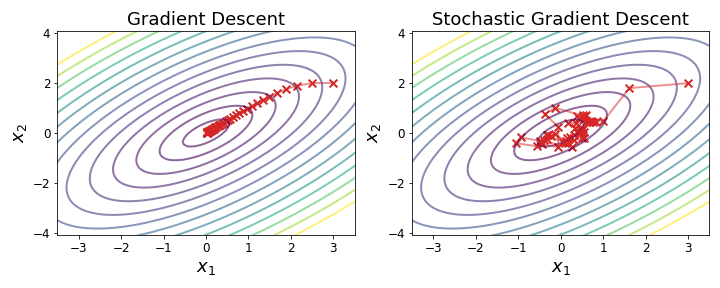


## Example: Multiclass Logistic Regression using SGD

Let us consider SGD on an image classification task using multiclass logistic regression in PyTorch.

In your previous course, you have used scikit-learn for multiclass logistic regression. We will instead use PyTorch, a leading framework for differentiable programming. We start with this familiar example and build towards multilayer perceptrons and other neural networks. 


We first visualize the data.

In [1]:
import numpy as np
import torch
from torchvision.datasets import FashionMNIST
from torch.nn.functional import cross_entropy
import time

import matplotlib.pyplot as plt 
%matplotlib inline 

# Fix the random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(1)

In [2]:
# download dataset (~117M in size)
train_dataset = FashionMNIST('./data', train=True, download=True)
X_train = train_dataset.data # torch tensor of type uint8 of shape (n, 28, 28)
y_train = train_dataset.targets.long() # torch tensor of type Long of shape (n,)
test_dataset = FashionMNIST('./data', train=False, download=True)
X_test = test_dataset.data
y_test = test_dataset.targets.long()

# choose a subsample of 10% of the data:
idxs_train = torch.from_numpy(
    np.random.choice(X_train.shape[0], replace=False, size=X_train.shape[0]//10))
X_train, y_train = X_train[idxs_train], y_train[idxs_train]
# idxs_test = torch.from_numpy(
#     np.random.choice(X_test.shape[0], replace=False, size=X_test.shape[0]//10))
# X_test, y_test = X_test[idxs_test], y_test[idxs_test]

print(f'X_train.shape = {X_train.shape}')
print(f'n_train: {X_train.shape[0]}, n_test: {X_test.shape[0]}')
print(f'Image size: {X_train.shape[1:]}')

X_train.shape = torch.Size([6000, 28, 28])
n_train: 6000, n_test: 10000
Image size: torch.Size([28, 28])


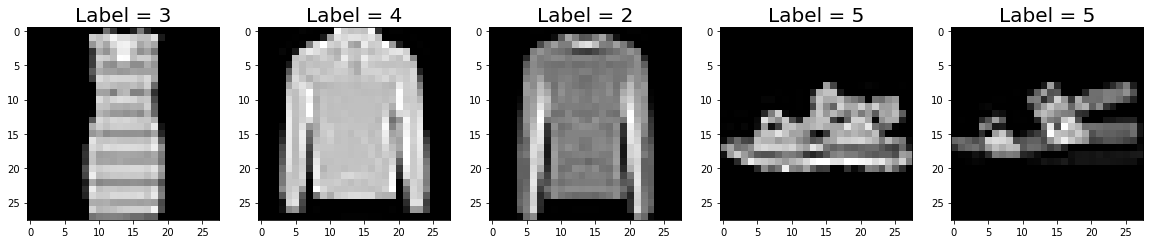

In [4]:
f, ax = plt.subplots(1, 5, figsize=(20, 4))
for i, idx in enumerate(np.random.choice(X_train.shape[0], 5)):
    ax[i].imshow(X_train[idx], cmap='gray', vmin=0, vmax=255)
    ax[i].set_title(f'Label = {y_train[idx]}', fontsize=20)

Let us normalize the data and define some utility functions. We start by flattening the $28 \times 28$ image into a vector of size $784$.

In [5]:
# Normalize dataset: pixel values lie between 0 and 255
# Normalize them so the pixelwise mean is zero and standard deviation is 1

X_train = X_train.float()  # convert to float32. Shape: (n, 28, 28)
X_train = X_train.view(-1, 784)  # Shape: (n, 784)
mean, std = X_train.mean(axis=0), X_train.std(axis=0)  # Shape: (784,)
# Normalize: add a small number to avoid divide by zero
X_train = (X_train - mean[None, :]) / (std[None, :] + 1e-6) # Shape: (n, 784)

X_test = X_test.float()  # Shape: (n', 28, 28)
X_test = X_test.view(-1, 784)  # Shape: (n', 784)
X_test = (X_test - mean[None, :]) / (std[None, :] + 1e-6)  # Shape: (n', 784)

n_class = np.unique(y_train).shape[0]  # We have K=10 classes numbered (0, 1, ..., 9)

### Review of multinomial logistic loss

In the previous course, you have seen linear models, which map an input $x \in \mathbb{R}^d$ (an image in our example) to a vector of $K=10$ scores, one for each of the $K$ classes:
$$
    \varphi(x; W) = W^\top x
$$
where $W \in \mathbb{R}^{d \times K}$ denotes the parameters of the model. 

Any set of scores can be converted to a probabilistic model $p(x; W)$ which assigns a probability to each class by using the softmax operation: 
$$
    [p(x; W)]_k = \frac{\exp\big([\varphi(x; W)]_k\big)}{\sum_{j=1}^K \exp\big([\varphi(x; W)]_j \big)} \,.
$$

**Exercise**: Verify that $p(x;W)$ is a valid probability distribution over $K$ items. That is, each entry is non-negative and the sum of all entries is 1. 

The model $\varphi( \cdot ; W)$ and its induced probabilities $p(\cdot ; W)$ are correct for input $x$ if it assigns a large probability to the correct class $y$. We use the multinomial logistic loss to this end. It is defined as
the negative of the log probability assigned to the correct class $y$. 
$$
\ell(y, p) = - \log p_y .
$$

**Exercise**: What is the smallest possible value of this loss? What is the largest possible value? What is its value under a model that selects a class uniformly at random?


### Coding this in PyTorch
We use a PyTorch function called `cross_entropy` that computes the multinomial logistic loss of a model $\varphi(\cdot ; w)$ by implicitly transforming the scores into a probabilities using the softmax function. 

In [6]:
def compute_objective(w, X, y, reg_param):
    """ Compute the multinomial logistic loss. 
        Require w of shape (d, K), X of shape (n, d) and y of shape (n,)
    """
    score = torch.matmul(X, w)  # shape: (n, K)
    # PyTorch's function cross_entropy computes the multinomial logistic loss
    return (
        cross_entropy(input=score, target=y, reduction='mean') 
        + 0.5 * reg_param * torch.norm(w)**2
    )

@torch.no_grad()
def compute_accuracy(w, X, y):
    """ Compute the classification accuracy
        Require w of shape (d, K), X of shape (n, d) and y of shape (n,)
    """
    score = torch.matmul(X, w)
    predictions = torch.argmax(score, axis=1)  # class with highest score is predicted
    return (predictions == y).sum() * 1.0 / y.shape[0]

@torch.no_grad()
def compute_logs(w, reg_param, verbose=False):
    train_loss = compute_objective(w, X_train, y_train, reg_param)
    test_loss = compute_objective(w, X_test, y_test, reg_param)
    train_accuracy = compute_accuracy(w, X_train, y_train)
    test_accuracy = compute_accuracy(w, X_test, y_test)
    if verbose:
        print(('Train Loss = {:.3f}, Train Accuracy = {:.3f}, ' + 
               'Test Loss = {:.3f}, Test Accuracy = {:.3f}').format(
                train_loss.item(), train_accuracy.item(), 
                test_loss.item(), test_accuracy.item())
    )
    return (train_loss, train_accuracy, test_loss, test_accuracy)

Let us compute the initial loss and accuracy. 
How does the accuracy relate to what we obtain from random guessing?
What is the multinomial logistic loss we expect with a model which guesses randomly?

In [7]:
reg_param = 0.1 / X_train.shape[0]

w = torch.zeros(784, n_class, requires_grad=True)

_ = compute_logs(w, reg_param, verbose=True)


Train Loss = 2.303, Train Accuracy = 0.098, Test Loss = 2.303, Test Accuracy = 0.100


Let us now make one pass over the data with SGD (meaning: we make as many SGD updates as the number of examples in our dataset). We call each pass through the data an **epoch**. 

In [8]:
def sgd_one_pass(w, X, y, reg_param, learning_rate, verbose=False):
    num_examples = X.shape[0]
    average_loss = 0.0
    for i in range(num_examples):
        idx = np.random.choice(X.shape[0])
        # compute the objective. 
        # Note: This function requires X to be of shape (n,d). In this case, n=1    
        objective = compute_objective(w, X[idx:idx+1], y[idx:idx+1], reg_param) 
        
        average_loss = 0.99 * average_loss + 0.01 * objective.item()
        if verbose and (i+1) % 100 == 0:
            print(average_loss)
        
        # compute the gradient using automatic differentiation
        gradient = torch.autograd.grad(outputs=objective, inputs=w)[0]
        
        # perform SGD update. Note: hide the update from autograd
        with torch.no_grad():
            w -= learning_rate * gradient
    return w

### Divergent Learning Rate

As we change the learning rate, there are two extreme regimes:

- If the learning rate is too large, the weights diverge to infinity (that is, the coordinates of $w$ increase without bound to $\pm\infty$).
- On the other hand, if the learning rate is too small, the optimization takes a very large number of iterations to converge (the per iteration cost is quite high for complex model). 

In order to balance these two, we look for the *divergent learning rate*. We say $\eta^\star$ is the divergent learning rate if SGD with a learning rate of $2\eta^\star$ diverges, but SGD with a learning rate of $\eta^\star$ does not. 

**Divergent LR Heuristic**: A good starting learning rate is $\eta^\star/2$. 

In [16]:
learning_rate = 0.01

w = torch.zeros(784, n_class, requires_grad=True)
_ = compute_logs(w, reg_param, verbose=True)


w = sgd_one_pass(w, X_train, y_train, reg_param, learning_rate, verbose=True)
_ = compute_logs(w, reg_param, verbose=True)


Train Loss = 2.303, Train Accuracy = 0.098, Test Loss = 2.303, Test Accuracy = 0.100
0.936557926762691
1.1803614791623018
1.337130951049917
1.2219908251683465
1.1245948222165412
1.4625295770931432
1.3024168257082158
1.0775098804007541
0.9832094740280913
1.375779405505481
0.9690099592058217
1.0311271941062983
0.8930918796064286
0.9406268626550025
1.1781470533624376
1.173865229521306
1.2171980529637296
1.4551314227785952
0.979215898852991
0.898763427791072
0.8348420201945776
1.1732183937857712
1.1760090053041383
1.0313486597535286
0.9715321318163187
1.0619839217842575
1.2102910942123493
0.8779805969214812
0.9858945208729225
1.2947435602781716
1.3941268745559448
1.2058661075815647
1.1142452328775994
1.2773937893976515
1.2125935609341387
1.2477257002994107
1.2505486848982235
1.0646252756318344
0.932109934817925
0.9376472548399559
1.1288091321395317
1.225746961516795
1.5722113749213376
1.3194547433920878
1.2401479309076189
1.1487917224498454
1.055720002231993
1.1104450249883429
1.1527174730

Now that we found a good learning rate, let us run it for multiple passes through the data and plot the train/test loss/accuracy. 

In [17]:
learning_rate = 0.01

logs = []

w = torch.zeros(784, n_class, requires_grad=True)
logs.append(compute_logs(w, reg_param, verbose=True))

for j in range(20):
    w = sgd_one_pass(w, X_train, y_train, reg_param, learning_rate, verbose=False)
    logs.append(compute_logs(w, reg_param, verbose=True))


Train Loss = 2.303, Train Accuracy = 0.098, Test Loss = 2.303, Test Accuracy = 0.100
Train Loss = 0.937, Train Accuracy = 0.792, Test Loss = 1.497, Test Accuracy = 0.743
Train Loss = 0.857, Train Accuracy = 0.821, Test Loss = 1.514, Test Accuracy = 0.775
Train Loss = 0.802, Train Accuracy = 0.836, Test Loss = 1.499, Test Accuracy = 0.779
Train Loss = 0.788, Train Accuracy = 0.835, Test Loss = 1.650, Test Accuracy = 0.774
Train Loss = 0.819, Train Accuracy = 0.852, Test Loss = 1.795, Test Accuracy = 0.781
Train Loss = 0.598, Train Accuracy = 0.865, Test Loss = 1.495, Test Accuracy = 0.783
Train Loss = 0.578, Train Accuracy = 0.875, Test Loss = 1.613, Test Accuracy = 0.790
Train Loss = 0.576, Train Accuracy = 0.878, Test Loss = 1.611, Test Accuracy = 0.791
Train Loss = 0.591, Train Accuracy = 0.877, Test Loss = 1.710, Test Accuracy = 0.786
Train Loss = 0.467, Train Accuracy = 0.888, Test Loss = 1.640, Test Accuracy = 0.783
Train Loss = 0.599, Train Accuracy = 0.870, Test Loss = 1.717, Te

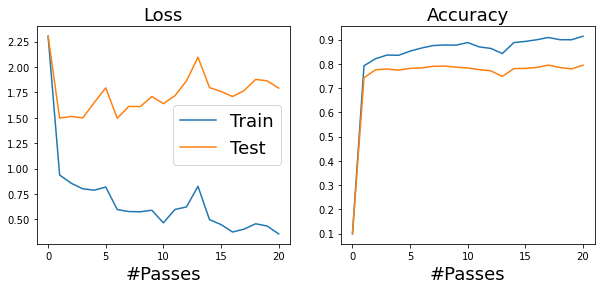

In [18]:
logs = np.asarray(logs)

f, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(logs[:, 0], label='Train')
ax[0].plot(logs[:, 2], label='Test')
ax[0].set_title('Loss', fontsize=18)
ax[0].set_xlabel('#Passes', fontsize=18)

ax[1].plot(logs[:, 1], label='Train')
ax[1].plot(logs[:, 3], label='Test')
ax[1].set_title('Accuracy', fontsize=18)
ax[1].set_xlabel('#Passes', fontsize=18)

ax[0].legend(fontsize=18)


# 2. Multi-layer perceptron
A multi-layer perceptron (MLP) is a sequence of compositions of linear functions and non-linear maps in the following form

- Linear $\longrightarrow$ Non-linear $\longrightarrow \cdots \longrightarrow$ Linear


Concretely, a MLP is a map $\varphi: \mathbb{R}^{d_0} \to \mathbb{R}^{d_L}$ that can be written as 
$$
    \varphi(x; W_1, \cdots, W_L, b_1, \cdots, b_L) = 
    W_L^\top \sigma\Big( W_{L-1}^\top \sigma\big( \cdots \sigma(W_1^\top x + b_1)\big) + b_{L-1} \Big) + b_L
$$

where $W_j \in \mathbb{R}^{d_{j-1}\times d_j}$ is a weight matrix and $b_j \in \mathbb{R}^{d_j}$ is a bias vector. Here, $\sigma: \mathbb{R} \to \mathbb{R}$ is a non-linear function which is applied element-wise. It is referred to as the *activation function*. 

Commonly used activation functions include:

- the rectified linear unit (ReLU) $\sigma(t) = \max\{t, 0\}$, and
- the sigmoid, $\sigma(t) = 1 / (1 + \exp(-t))$.

Note that the final linear map is not followed by a non-linearity. This MLP is said to have $L-1$ *hidden layers*. The $j$th hidden layer is the linear map defined by $(W_{j-1}, b_{j-1})$.

*Linear MLP*: The simplest MLP is the case $L=1$. In this case, we have $L-1=0$ hidden layers and $L-1=0$ applications of the non-linearity. In this case, we recover the linear model $\varphi(x; W) = W^\top x$. 

![MLP](https://upload.wikimedia.org/wikipedia/commons/2/28/MultiLayerPerceptron.png)

As a recursion, we can write
$$
z_0 = x
$$
and 
$$
z_{j} = \sigma(W_j^\top z_{j-1} + b_j) \, \text{ for } j = 1, \cdots, L.
$$

Note that $j$th hidden layer outputs $z_j$ for $j = 1, \cdots, L-1$.

**Notation**: We will denote all the weights in the MLP as $w = (W_1, \cdots, W_L)$ 
and the biases as $b = (b_1, \cdots, b_L)$. 

**Example**: Let us modify the multi-class logistic regression from above to use a MLP instead of the linear model.
    
   For simplicity, we fix the bias terms $b_j = 0$ below and use the ReLU non-linearity.

We start by writing out functions to compute the objective and the accuracy again. 

In [19]:
# Some utility functions to compute the objective and the accuracy

def mlp(X, ws, bs):
    hidden = X # Shape: (n, d_0)
    for w, b in zip(ws[:-1], bs[:-1]):
        hidden = torch.matmul(hidden, w) + b[None, :]  # Shape: (n, d_{j-1}) * (d_{j-1}, d_j) = (n, d_j)
        hidden = torch.nn.functional.relu(hidden)
    return torch.matmul(hidden, ws[-1]) + bs[-1][None, :]

def compute_objective(ws, bs, X, y, reg_param):
    """ Compute the multinomial logistic loss. 
        ws is a list of tensors of consistent shapes,
        X of shape (n, d) and y of shape (n,)
    """
    score = mlp(X, ws, bs)  # Shape: (n, K)
    # PyTorch's function cross_entropy computes the multinomial logistic loss
    return (
        cross_entropy(input=score, target=y, reduction='mean') 
        + 0.5 * reg_param * sum([torch.norm(w)**2 for w in ws])
    )

@torch.no_grad()
def compute_accuracy(ws, bs, X, y):
    """ Compute the classification accuracy
        ws is a list of tensors of consistent shapes 
        X of shape (n, d) and y of shape (n,)
    """
    score = mlp(X, ws, bs)  # shape: (n, K`)
    predictions = torch.argmax(score, axis=1)  # class with highest score is predicted
    return (predictions == y).sum() * 1.0 / y.shape[0]

@torch.no_grad()
def compute_logs(ws, bs, reg_param, verbose=False):
    train_loss = compute_objective(ws, bs, X_train, y_train, reg_param)
    test_loss = compute_objective(ws, bs, X_test, y_test, reg_param)
    train_accuracy = compute_accuracy(ws, bs, X_train, y_train)
    test_accuracy = compute_accuracy(ws, bs, X_test, y_test)
    if verbose:
        print(('Train Loss = {:.3f}, Train Accuracy = {:.3f}, ' + 
               'Test Loss = {:.3f}, Test Accuracy = {:.3f}').format(
                train_loss.item(), train_accuracy.item(), 
                test_loss.item(), test_accuracy.item())
    )
    return (train_loss, train_accuracy, test_loss, test_accuracy)

In [20]:
reg_param = 0.0

hidden_size = 1024
ws = [torch.zeros(784, hidden_size, requires_grad=True),
      torch.zeros(hidden_size, n_class, requires_grad=True)]
bs = [torch.zeros(hidden_size, requires_grad=True),
      torch.zeros(n_class, requires_grad=True)]

_ = compute_logs(ws, bs, reg_param, verbose=True)


Train Loss = 2.303, Train Accuracy = 0.098, Test Loss = 2.303, Test Accuracy = 0.100


Let us again write the analogous function to make a pass of SGD.

In [21]:
def sgd_one_pass(ws, bs, X, y, reg_param, learning_rate, verbose=False):
    num_examples = X.shape[0]
    average_loss = 0.0
    for i in range(num_examples):
        idx = np.random.choice(X.shape[0])
        # compute the objective. 
        # Note: This function requires X to be of shape (n,d). In this case, n=1 
        objective = compute_objective(ws, bs, X[idx:idx+1], y[idx:idx+1], reg_param) 
        average_loss = 0.99 * average_loss + 0.01 * objective.item()
        if verbose and (i+1) % 100 == 0:
            print(average_loss)
        
        # compute the gradient using automatic differentiation
        all_parameters = [*ws, *bs]
        gradients = torch.autograd.grad(outputs=objective, inputs=all_parameters)
        
        # perform SGD update. IMPORTANT: Make the update inplace!
        with torch.no_grad():
            for (w, g) in zip(all_parameters, gradients):
                w -= learning_rate * g
    return ws, bs

Next, we find the divergence learning rate. The procedure to find the divergent learning is the same as previously.

The one difference, however, is that *initializing the weights at zero will no longer work*.
This is because the gradient at $w = 0$ is exactly zero. (Exercise: work this out!)

For now, we shall initialize the weights randomly with a small weight. We shall come back to how to initialize the weights.

In [28]:
learning_rate = 0.01 / 2

hidden_size = 512
ws = [1e-6 * torch.randn(784, hidden_size, requires_grad=True),
      1e-6 * torch.randn(hidden_size, n_class, requires_grad=True)]
bs = [torch.zeros(hidden_size, requires_grad=True),
      torch.zeros(n_class, requires_grad=True)]

_ = compute_logs(ws, bs, reg_param, verbose=True)


ws, bs = sgd_one_pass(ws, bs, X_train, y_train, reg_param, learning_rate, verbose=True)
_ = compute_logs(ws, bs, reg_param, verbose=True)


Train Loss = 2.303, Train Accuracy = 0.120, Test Loss = 2.303, Test Accuracy = 0.129
1.4602604373218377
1.9940144572473233
2.1894796459194232
2.260811679617007
2.2865531218712203
2.2968509781830626
2.3031024500890083
2.3028382365122395
2.2998255091235604
2.275811772791252
2.0951387826122994
2.0337336080539767
1.8435875916724203
1.6702744142848476
1.5130129805742778
1.4497295284741505
1.3493978241773195
1.3518187142703229
1.1948392799204324
1.1334345829889916
1.080889169738534
0.9646255988888932
0.9088420520311271
0.9327375268463309
0.8827992195088782
0.9458633460878089
0.7921616960134534
0.8536770550601172
0.7605789041482381
0.6913682478011163
0.6654753934274767
0.713134591709878
0.7086040785424385
0.7235689319229954
0.6784622701215729
0.760133584512258
0.7746884686077643
0.7712910103670392
0.6830146903228069
0.7581231443688726
0.7382330673504429
0.6456296860928425
0.5368536362222507
0.49137505486680305
0.6167022206961629
0.6285473630541749
0.5612541516582139
0.5440354785394349
0.55653

In [29]:
learning_rate = 5e-3

logs = []

ws = [1e-6 * torch.randn(784, hidden_size, requires_grad=True),
      1e-6 * torch.randn(hidden_size, n_class, requires_grad=True)]
bs = [torch.zeros(hidden_size, requires_grad=True),
      torch.zeros(n_class, requires_grad=True)]
logs.append(compute_logs(ws, bs, reg_param, verbose=True))

for j in range(40):
    print(j+1, end=', ')
    ws, bs = sgd_one_pass(ws, bs, X_train, y_train, reg_param, learning_rate, verbose=False)
    logs.append(compute_logs(ws, bs, reg_param, verbose=True))


Train Loss = 2.303, Train Accuracy = 0.115, Test Loss = 2.303, Test Accuracy = 0.117
1, Train Loss = 0.575, Train Accuracy = 0.784, Test Loss = 0.651, Test Accuracy = 0.770
2, 

KeyboardInterrupt: 

In [13]:
import pickle as pkl
with open('fashion__mlp_weights.p', 'wb') as f:
    pkl.dump([ws, bs], f)

The same setting, when run for 100 passes over the data, gives the following result. 

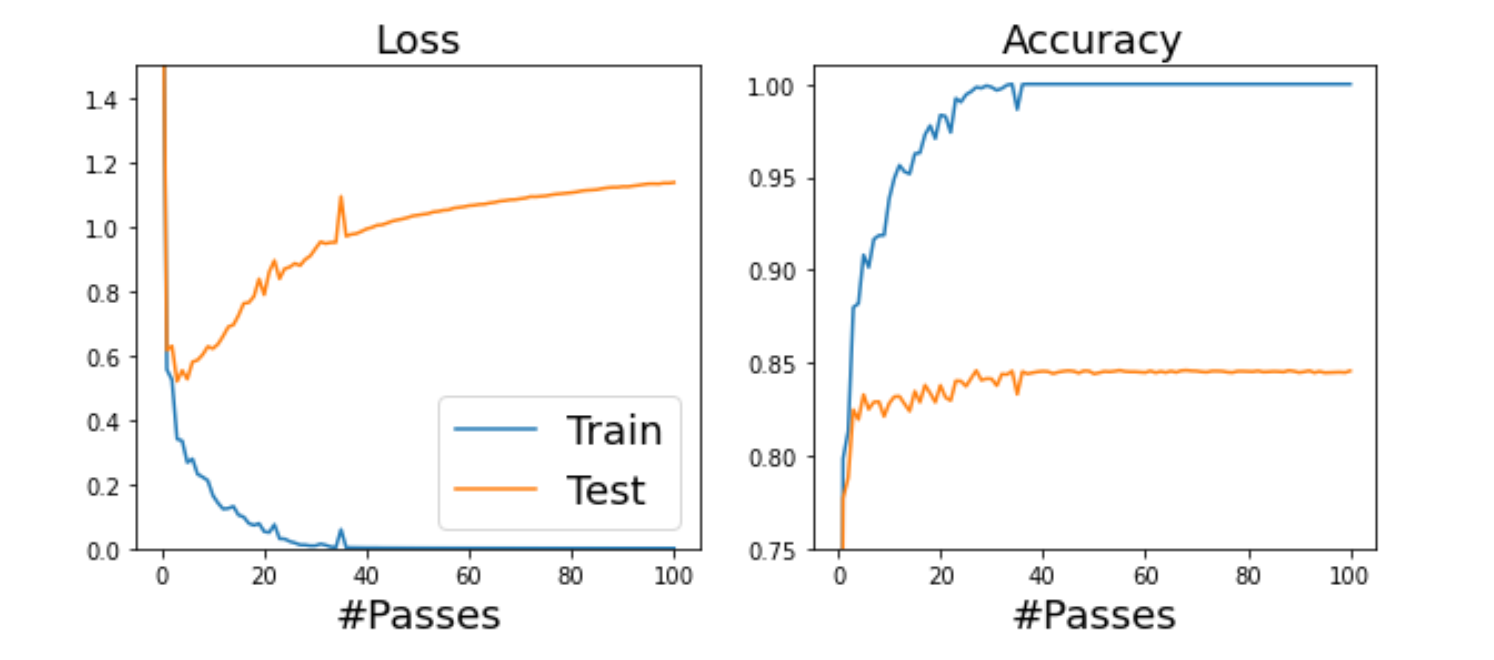

Let play with the initialization schemes now. 

- Try initializing with 0. What happens?
- Try increasing the variance from 0 to 1e-20, 1e-10, 1e-6, 1e-3 and 1e-1. What do you observe?
- Try out the so-called Glorot initialization scheme, where $W_j \in \mathbb{R}^{d_{j-1}\times d_j}$ is taken to be be normally distributed with variance $1/d_{j}$.

In [35]:
learning_rate = 2.5e-3

ws = [1e-6 * torch.randn(784, hidden_size, requires_grad=True),
      1e-6 * torch.randn(hidden_size, n_class, requires_grad=True)]
bs = [torch.zeros(hidden_size, requires_grad=True),
      torch.zeros(n_class, requires_grad=True)]
_ = compute_logs(ws, bs, reg_param, verbose=True)


ws = sgd_one_pass(ws, bs, X_train, y_train, reg_param, learning_rate, verbose=True)
_ = compute_logs(ws, bs, reg_param, verbose=True)


Train Loss = 2.303, Train Accuracy = 0.034, Test Loss = 2.303, Test Accuracy = 0.034
1.4599481186531302
1.9940066322674774
2.1901552920448575
2.260726220043116
2.2877998157812813
2.297733504561663
2.3012688722195622
2.3013961002723904
2.300171857387694
2.303091861777451
2.303781023825399
2.3014390143809025
2.3033625753886224
2.3028083356633267
2.3034577389810575
2.3005113983465697
2.291688319168844
2.253611644331916
2.2042052569579442
2.1253322440620854
2.0965951204062163
2.059119674388688
1.9539189719269066
1.8798321337726132
1.7898924060682742
1.6379425635083116
1.4746698500103355
1.4319305394965312
1.4368890126950988
1.3298283991172968
1.2669237617819833
1.2914078319130307
1.2444168712396297
1.1028394898196172
1.1319891454159263
1.102309007583212
1.2254037040903918
1.201519892402951
1.1031649750387362
1.1127268189979984
1.07402637788299
1.0527494045589483
0.9238807243140457
0.9671476083933025
0.9497272069170201
0.9934785900522835
0.8783532617670001
0.8234010724815638
0.7745622655006

TypeError: matmul(): argument 'other' (position 2) must be Tensor, not list